# Measuring the Innovation Impact of an Organization using Patents Citations

This notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to analyze the innovation impact of an organization. 

There are **two ways** to achieve this. The **first method** is counting how many patents have inventors (assignees) affiliated to the GRID organization we are interested in. This method returns the *direct* innovation impact of an organization, which can be easily achieved via a single [patents API](https://docs.dimensions.ai/dsl/datasource-patents.html) query: 

```
> search patents where assignees in ["grid.89170.37"] return patents limit 500
Returned Patents: 192 
---
[1] METHODS AND SYSTEMS FOR OBJECT IDENTIFICATION AND FOR AUTHENTICATION (id: https://app.dimensions.ai/details/patent/WO-2007149621-A3 )
[2] ADENOVIRAL VECTOR-BASED MALARIA VACCINES (id: https://app.dimensions.ai/details/patent/EP-1929021-A2 )
[3] MULTIPLE BAND SHORT WAVE INFRARED MOSAIC ARRAY FILTER (id: https://app.dimensions.ai/details/patent/WO-2016040755-A1 )
[4] ARMOR PLATE (id: https://app.dimensions.ai/details/patent/WO-2011142867-A3 )
..etc..
```

The **second method** - which is what we demonstrate in this tutorial - permits instead to gain some insights into the *indirect* innovation impact of a research organization. This can be achieved by extracting patents that **cite** publications from that research organization.  

Since the various content-types included in the Dimensions database are [deeply interlinked](https://docs.dimensions.ai/dsl/data-sources.html), the Dimensions APIs allow to perform this analysis via a few simple steps: 

* We start from a [GRID](https://grid.ac/) identifier (representing a research organization in Dimensions) 
* We use the [publications API](https://docs.dimensions.ai/dsl/datasource-publications.html) to extract all publications where at least one author is/as affiliated to the GRID organization, for a selected time-period
* We then use the [patents API](https://docs.dimensions.ai/dsl/datasource-patents.html) to discover patents that include citations to any of those publications 
* Finally, we analyse the patents data to highlight trends e.g. about countries, inventors etc.. 


## Prerequisites

Please install the latest versions of these libraries to run this notebook. 

In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.shortcuts import *
import json
import sys
import os
import time
from tqdm.notebook import tqdm as progressbar
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://github.com/digital-science/dimcli#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  USERNAME = getpass.getpass(prompt='Username: ')
  PASSWORD = getpass.getpass(prompt='Password: ')    
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
else:
  USERNAME, PASSWORD  = "", ""
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.7.4.2)
Connected to: https://app.dimensions.ai - DSL v1.27
Method: dsl.ini file


## 1. Choosing a GRID Research Organization

For the purpose of this exercise, we are going to use [grid.4305.2](https://grid.ac/institutes/grid.4305.2) (The Open University, UK). Feel free  to change the parameters below as you want, eg by [choosing another GRID organization](https://grid.ac/institutes).

In [3]:

GRIDID = "grid.10837.3d" #@param {type:"string"}

#@markdown The start/end year of publications used to extract patents
YEAR_START = 2005 #@param {type: "slider", min: 1950, max: 2020}
YEAR_END = 2015 #@param {type: "slider", min: 1950, max: 2020}

if YEAR_END < YEAR_START:
  YEAR_END = YEAR_START

from IPython.core.display import display, HTML
display(HTML('---<br /><a href="{}">Open in Dimensions &#x29c9;</a>'.format(dimensions_url(GRIDID))))

#@markdown ---


## 2. Extracting Publications Data

By looking at the [Dimensions API data model](https://docs.dimensions.ai/dsl/data-sources.html), we can see that Patents and Publications are connected by a property called `publication_ids`, which goes *from* Patents *to* Publications. This property represents the publications citations found in patents.

Hence, we need to
1. query for all publications with authors affiliated to our GRID ID
2. query for patents citing these publications 

In [4]:
# Get full list of publications linked to this organization for the selected time frame

q = f"""search publications 
        where research_orgs.id="{GRIDID}" 
        and year in [{YEAR_START}:{YEAR_END}]
        return publications[id+doi+title+type+journal+year+research_orgs+researchers+category_for+times_cited]"""
print("===\n", q, "\n===")
pubs_json = dsl.query_iterative(q, limit=1000)
pubs = pubs_json.as_dataframe()

===
 search publications 
        where research_orgs.id="grid.10837.3d" 
        and year in [2005:2015]
        return publications[id+doi+title+type+journal+year+research_orgs+researchers+category_for+times_cited] 
===
Starting iteration with limit=1000 skip=0 ...
0-1000 / 9026 (2.09s)
1000-2000 / 9026 (2.15s)
2000-3000 / 9026 (2.24s)
3000-4000 / 9026 (1.53s)
4000-5000 / 9026 (1.50s)
5000-6000 / 9026 (2.05s)
6000-7000 / 9026 (1.76s)
7000-8000 / 9026 (1.28s)
8000-9000 / 9026 (1.68s)
9000-9026 / 9026 (0.48s)
===
Records extracted: 9026


In [5]:
pubs.head()

times_cited     type                                      research_orgs  \
0            2  article  [{'id': 'grid.10837.3d', 'acronym': 'OU', 'nam...   
1            0  article  [{'id': 'grid.9026.d', 'acronym': 'UH', 'name'...   
2            6  article  [{'id': 'grid.463945.9', 'acronym': 'LPGN', 'n...   
3            1  article  [{'id': 'grid.10837.3d', 'acronym': 'OU', 'nam...   
4            0  article  [{'id': 'grid.10837.3d', 'acronym': 'OU', 'nam...   

                                               title  \
0  Do people choose to be homeless? An existentia...   
1  PLASIM-GENIE: a new intermediate complexity AOGCM   
2  Perspective – synthetic DEMs: A vital underpin...   
3  Shared dilemmas, choice and autonomy in the ma...   
4  Bruising in older adults: what do social worke...   

                                        category_for  \
0  [{'id': '3448', 'name': '1608 Sociology'}, {'i...   
1  [{'id': '2204', 'name': '04 Earth Sciences'}, ...   
2  [{'id': '2204', 'name': '04 Earth Sciences'}, ...   
3  [{'id': '3177', 'name': '1117 Public Health an...   
4  [{'id': '3177', 'name': '1117 Public Health an...   

                         doi              id  year  \
0   10.1108/hcs-07-2015-0013  pub.1028750505  2015   
1  10.5194/gmdd-8-10677-2015  pub.1038820736  2015   
2   10.5194/esurf-3-587-2015  pub.1014068242  2015   
3  10.1108/mhrj-07-2014-0025  pub.1045552756  2015   
4   10.1108/jap-11-2014-0035  pub.1046891576  2015   

                                         researchers    journal.id  \
0  [{'id': 'ur.014121733420.41', 'first_name': 'S...  jour.1046873   
1  [{'id': 'ur.015722150315.42', 'first_name': 'P...  jour.1371971   
2  [{'id': 'ur.015045402162.42', 'first_name': 'J...  jour.1146353   
3  [{'id': 'ur.014121733420.41', 'first_name': 'S...  jour.1023878   
4  [{'id': 'ur.07357206671.63', 'first_name': 'Sa...  jour.1023876   

                                 journal.title  
0                     Housing Care and Support  
1  Geoscientific Model Development Discussions  
2                       Earth Surface Dynamics  
3                 Mental Health Review Journal  
4              The Journal of Adult Protection

### Quick look at publications statistics 


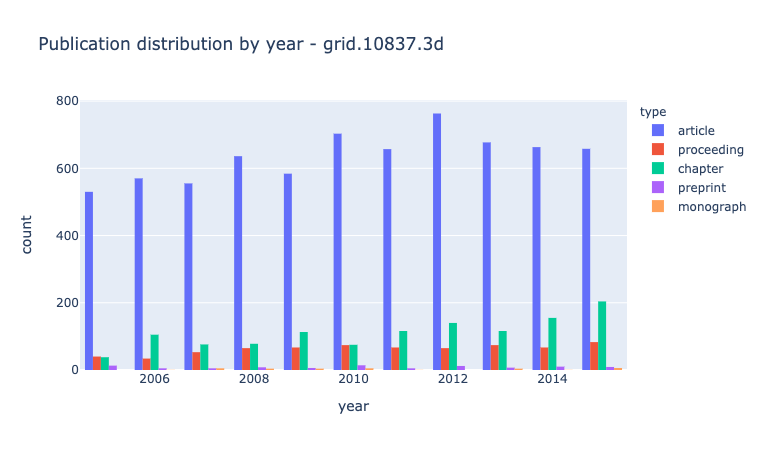

In [6]:
px.histogram(pubs, 
             x="year", 
             color="type", 
             barmode="group", 
             title=f"Publication distribution by year - {GRIDID}")

### What are the main subject areas? 

We can use the Field of Research categories information in publications to obtain a breakdown of the publications by subject areas. 

This can be achieved by 'exploding' the `category_for` data into a separate table, since there can be more than one category per publication. The new categories table also retains some basic info about the publications it relates to eg *journal*, *title*, *publication id* etc.. so to make it easier to analyse the data. 

In [7]:
pubs_categories = pubs.explode('category_for')
pubs_categories.dropna(subset=["category_for"], inplace=True)

def for_nice_name(for_dict):
    "transforms a category JSON into a nice looking title"
    if type(for_dict) == dict:
        name = for_dict['name']
        return ''.join([i for i in name if not i.isdigit()])
    else:
        return ""

# new col for nice name
pubs_categories["category_for_name"] = pubs_categories['category_for'].apply(lambda x: for_nice_name(x))
# new col for tot-pubs count
pubs_categories['count_pubs'] = pubs_categories.groupby("category_for_name")['id'].transform('count')

Let's view the top categories using a pie chart.

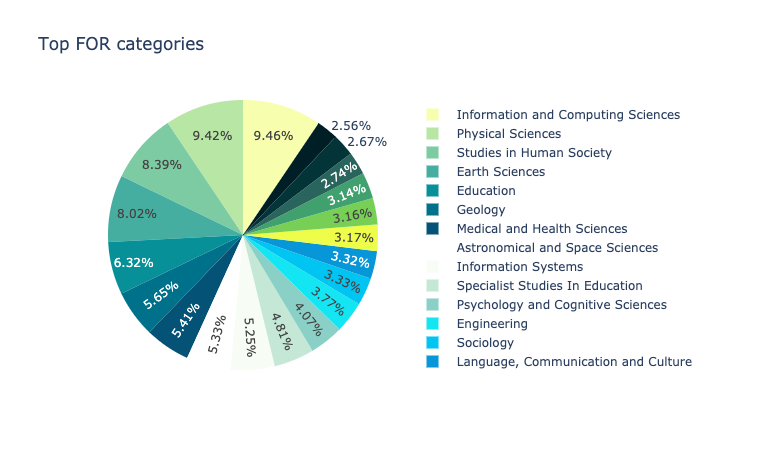

In [8]:
categories = pubs_categories.drop_duplicates(subset="category_for_name").sort_values("count_pubs", ascending=False)[['category_for_name', 'count_pubs']]

px.pie(categories[:20], 
       names="category_for_name", # the dimension for the slices
       values="count_pubs",  # the metric
       color_discrete_sequence=px.colors.sequential.Bluyl,
       title=f"Top FOR categories")

## 3. Extracting Patents linked to Publications

In this section we extract all patents linked to the publications dataset previously created. The steps are the following:

* we loop over the publication IDs and create patents queries, via the referencing `publication_ids` field of patents
* we collate all patens data, remove duplicates from patents and save the results 
* finally, we count patents per publication and enrich the original publication dataset with these numbers  

In [9]:
#
# the main patents query
#
q = """search patents 
        where publication_ids in {} 
      return patents[basics+publication_ids+category_for]"""

BATCHSIZE = 400
VERBOSE = False # set to True to see patents extraction logs


#
# loop through all pub IDs in chunks and query patents 
#
print("===\nExtracting patents data ...")
patents_json = []
pubsids = pubs['id']

for chunk in progressbar(list(chunks_of(list(pubsids), 400))):
    data = dsl.query_iterative(q.format(json.dumps(chunk)), verbose=VERBOSE)
    patents_json += data.patents
    time.sleep(1)
    

patents = pd.DataFrame().from_dict(patents_json)
patents.drop_duplicates(subset='id', inplace=True)
print("Patents found: ", len(patents))

===
Extracting patents data ...



Patents found:  157


Let's preview the data

In [10]:
patents.head(5)

id                                     assignee_names  \
0    WO-2015015185-A1                                        [UNIV OPEN]   
1       US-9993581-B2  [UCL Business Ltd, THE OPEN UNIV, UCL BUSINESS...   
2    WO-2017149513-A1                         [PROTHENA BIOSCIENCES LTD]   
3  DE-102015223347-A1  [Commissariat a lEnergie Atomique et aux Energ...   
5      US-10062704-B2  [Semiconductor Manufacturing International Sha...   

  publication_date                                          assignees  \
0       2015-02-05  [{'id': 'grid.10837.3d', 'acronym': 'OU', 'nam...   
1       2018-06-12  [{'id': 'grid.83440.3b', 'acronym': 'UCL', 'na...   
2       2017-09-08  [{'id': 'grid.482406.c', 'name': 'Prothena (Ir...   
3       2016-06-02  [{'id': 'grid.437359.f', 'name': 'Soitec (Fran...   
5       2018-08-28  [{'id': 'grid.471325.6', 'acronym': 'SMIC', 'n...   

                                      inventor_names  \
0               [PHILLIPS, JAMES, GEORGIOU, Melanie]   
1                 [James Phillips, Melanie Georgiou]   
2            [NESS, DANIEL KEITH, FLANAGAN, KENNETH]   
3  [Didier Landru, Capucine Delage, Franck Fourne...   
5  [Tzu Yin Chiu, Clifford Ian Drowley, Leong Tee...   

                                        category_for  \
0  [{'id': '2581', 'name': '0601 Biochemistry and...   
1  [{'id': '2581', 'name': '0601 Biochemistry and...   
2                                                NaN   
3  [{'id': '2921', 'name': '0912 Materials Engine...   
5  [{'id': '2471', 'name': '0306 Physical Chemist...   

                                               title  year filing_status  \
0                           ENGINEERED NEURAL TISSUE  2014   Application   
1                           Engineered neural tissue  2014         Grant   
2  ANTI-MCAM ANTIBODIES AND ASSOCIATED METHODS OF...  2017   Application   
3              PROCESS FOR CONNECTING TWO SUBSTRATES  2015   Application   
5  Buried-channel MOSFET and a surface-channel MO...  2016         Grant   

                                     publication_ids  granted_year  \
0  [pub.1038537221, pub.1007759342, pub.104762245...           NaN   
1  [pub.1022718673, pub.1000691651, pub.103853722...        2018.0   
2  [pub.1036841477, pub.1014162397, pub.104598330...           NaN   
3                                   [pub.1039579399]           NaN   
5   [pub.1061595798, pub.1061593545, pub.1061462502]        2018.0   

   times_cited  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
5          NaN

### Enriching publications with patents citations metrics

Each patent record contains all the `publication_ids` it cites, so we can take this metric so to enrich the original publications dataset we created above. 

In [11]:
def count_patents_per_pub(pubid):
  global patents
  return len(patents[patents['publication_ids'].str.contains(pubid)])

# turn lists into strings to ensure compatibility with CSV loaded data
# see also: https://stackoverflow.com/questions/23111990/pandas-dataframe-stored-list-as-string-how-to-convert-back-to-list
patents['publication_ids'] = patents['publication_ids'].apply(lambda x: ','.join(map(str, x))) 

progressbar.pandas()
pubs['patents'] = pubs['id'].progress_apply(lambda x: count_patents_per_pub(x))

/Users/michele.pasin/Envs/jupyterlab/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning:

The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version



Now the `patents` column gives us the top publications by number of citing patents

In [12]:
pubs.sort_values("patents", ascending=False).head()

times_cited     type                                      research_orgs  \
8499          844  article  [{'id': 'grid.428999.7', 'linkout': ['http://w...   
5211           37  article  [{'id': 'grid.10837.3d', 'acronym': 'OU', 'nam...   
2896           84  article  [{'id': 'grid.462098.1', 'longitude': 2.338753...   
8714           11  article  [{'id': 'grid.10837.3d', 'linkout': ['http://w...   
8307          114  article  [{'id': 'grid.493299.c', 'linkout': ['http://w...   

                                                  title  \
8499  Blood‐brain barrier‐specific properties of a h...   
5211  Modification of thiol functionalized aptamers ...   
2896  Cell‐penetrating anti‐GFAP VHH and correspondi...   
8714  Amyloid Precursor Protein: From Synaptic Plast...   
8307  An EXAFS study of the formation of a nanoporou...   

                                           category_for  \
8499  [{'id': '3120', 'name': '1109 Neurosciences'},...   
5211  [{'id': '2203', 'name': '03 Chemical Sciences'...   
2896  [{'id': '3120', 'name': '1109 Neurosciences'},...   
8714  [{'id': '3120', 'name': '1109 Neurosciences'},...   
8307  [{'id': '2203', 'name': '03 Chemical Sciences'...   

                          doi              id  year  \
8499    10.1096/fj.04-3458fje  pub.1002742563  2005   
5211        10.1021/bc900397s  pub.1055155906  2010   
2896     10.1096/fj.11-201384  pub.1033473743  2012   
8714  10.1196/annals.1342.014  pub.1004641182  2005   
8307         10.1039/b600709k  pub.1014463103  2006   

                                            researchers    journal.id  \
8499  [{'id': 'ur.01351646547.75', 'orcid_id': ['000...  jour.1017429   
5211  [{'id': 'ur.01124615125.34', 'first_name': 'Ch...  jour.1100499   
2896  [{'id': 'ur.01027626121.41', 'research_orgs': ...  jour.1017429   
8714  [{'id': 'ur.01333733704.35', 'last_name': 'Mil...  jour.1002487   
8307  [{'id': 'ur.01040541162.25', 'orcid_id': ['000...  jour.1297159   

                                   journal.title  patents  
8499                           The FASEB Journal       16  
5211                      Bioconjugate Chemistry       14  
2896                           The FASEB Journal        9  
8714  Annals of the New York Academy of Sciences        5  
8307                     Chemical Communications        5

## 4. Patents Data Analysis

Now that we have extracted all the data we need, let's start exploring them by building a few visualizations. 

###  How many patents per year? 

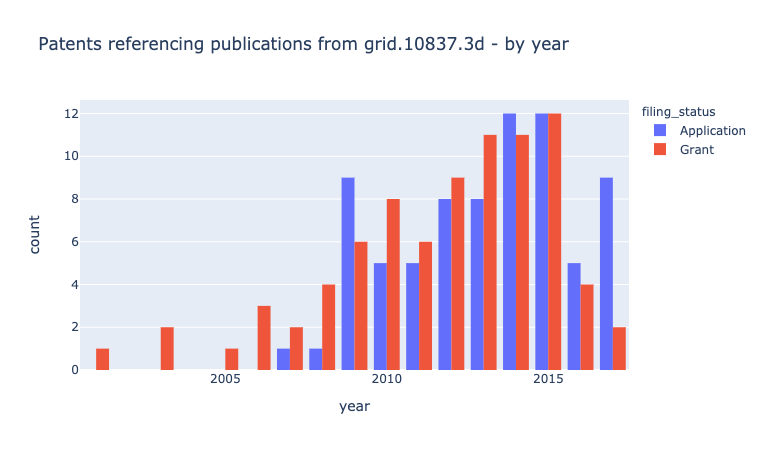

In [13]:
px.histogram(patents, x="year", 
             color="filing_status", 
             barmode="group", 
             title=f"Patents referencing publications from {GRIDID} - by year")

### Who is filing the patents?

This can be done by looking at the field `assigness` of patent. Since the field contains nested information, first we need to extract it into its own table (similarly to what we've done above with publications categories). 

In [15]:
# ensure the key exists in all rows (even if empty) 
from dimcli.shortcuts import normalize_key
normalize_key('assignees', patents_json)
# explode assigness into separate table 
patents_assignees = pd.json_normalize(patents_json, 
                                   record_path=['assignees'], 
                                   meta=['id', 'year', 'title'], 
                                   meta_prefix="patent_", 
                                errors="ignore")
top_assignees = patents_assignees.groupby(['name', 'country_name'],  
                                          as_index=False).count().sort_values(by="patent_id", ascending=False)
# preview the data: ps the patent_id column is the COUNT of patents
top_assignees[['name', 'country_name', 'patent_id']].head()

name    country_name  patent_id
51                                Pasteur Institute          France         11
21   French National Centre for Scientific Research          France         10
20  French Institute of Health and Medical Research          France         10
66                              The Open University  United Kingdom          8
85             Wisconsin Alumni Research Foundation   United States          6

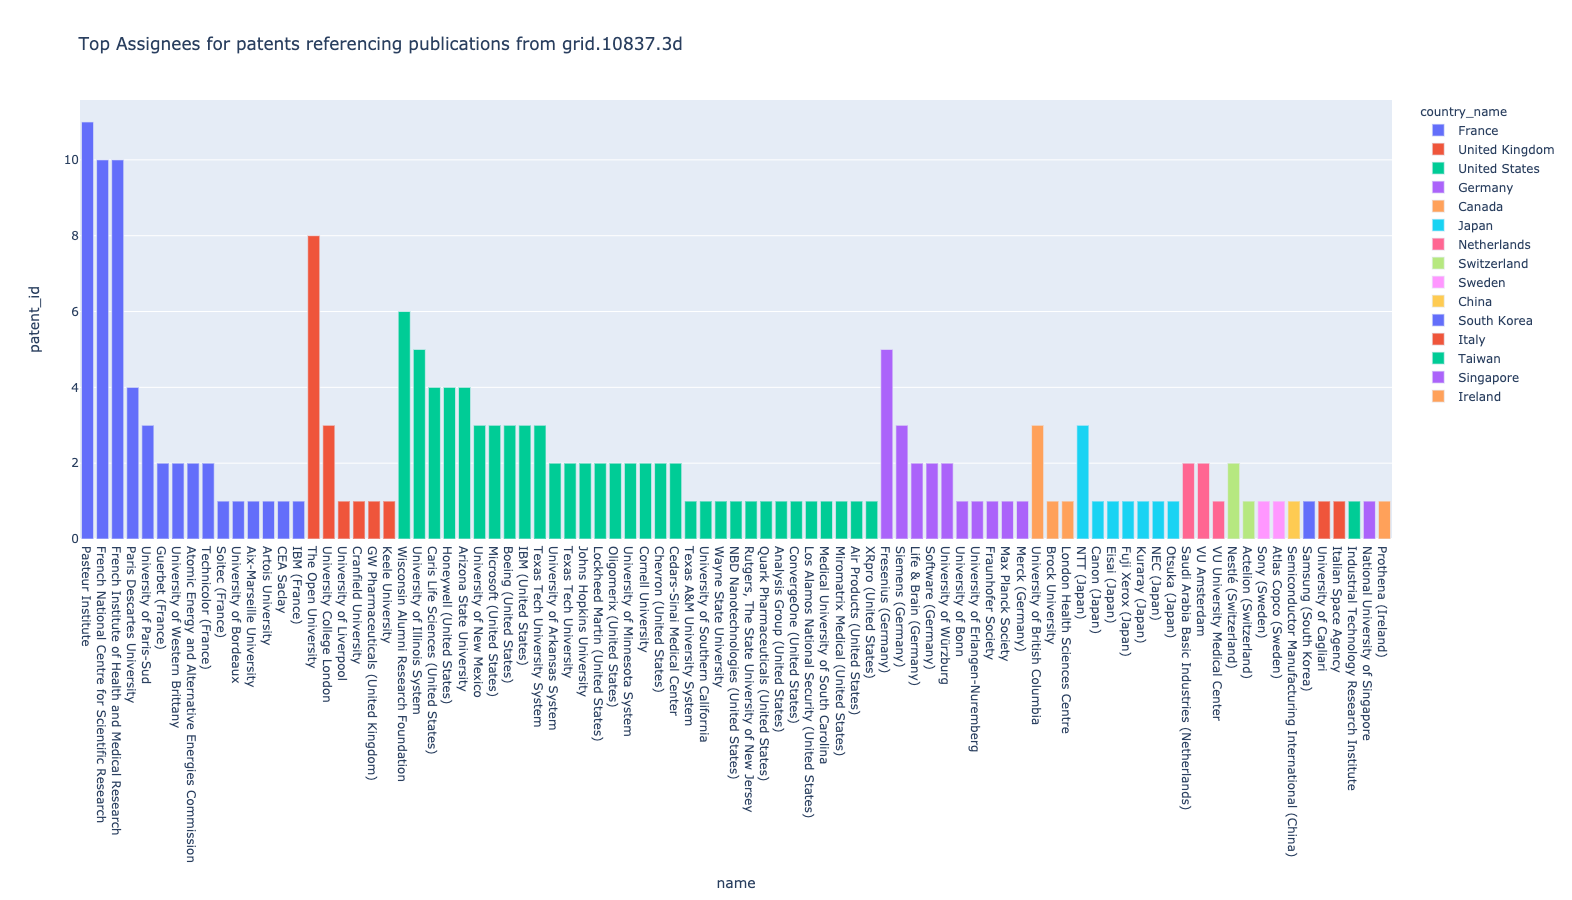

In [16]:
px.bar(top_assignees, 
       x="name", y="patent_id", 
       hover_name="name", color="country_name",
       height=900,
       title=f"Top Assignees for patents referencing publications from {GRIDID}")

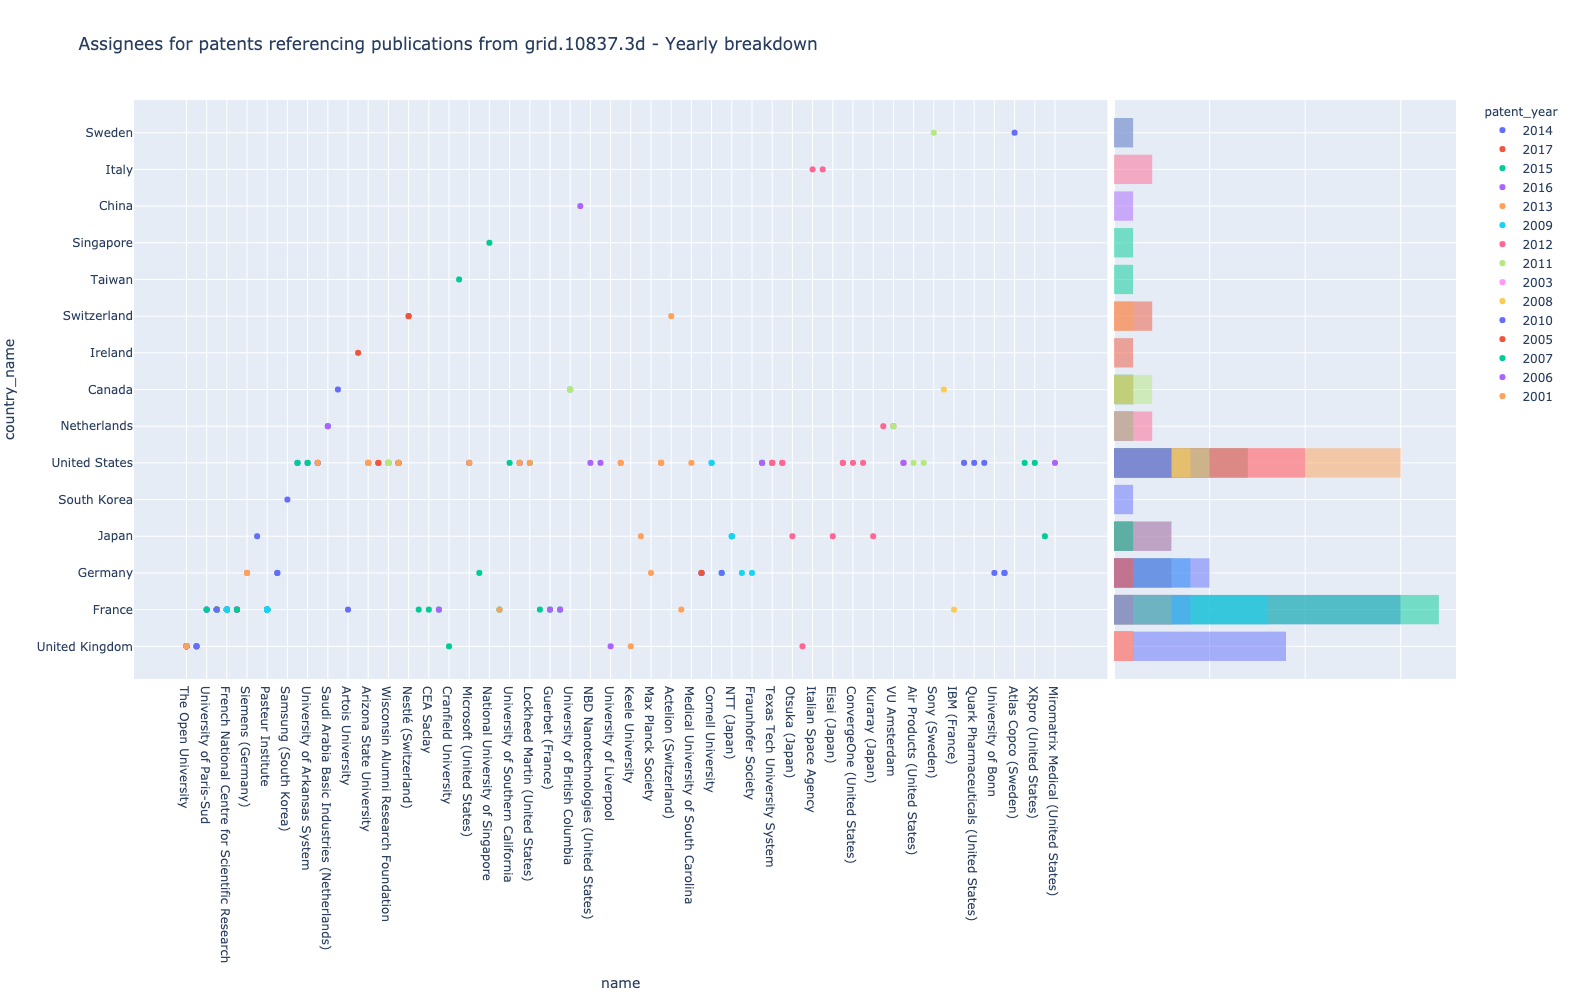

In [17]:
px.scatter(patents_assignees,  
           x="name", y="country_name", 
           color="patent_year", hover_name="name",  
           height = 1000,
           hover_data=["id", "patent_id"],  marginal_y="histogram",
           title=f"Assignees for patents referencing publications from {GRIDID} - Yearly breakdown")

### What are the publications most frequenlty referenced in patents?

In [18]:
pubs_cited = pubs.query("patents > 0 ").sort_values('patents', ascending=False).copy()
pubs_cited.head()

times_cited     type                                      research_orgs  \
8499          844  article  [{'id': 'grid.428999.7', 'linkout': ['http://w...   
5211           37  article  [{'id': 'grid.10837.3d', 'acronym': 'OU', 'nam...   
2896           84  article  [{'id': 'grid.462098.1', 'longitude': 2.338753...   
8714           11  article  [{'id': 'grid.10837.3d', 'linkout': ['http://w...   
8307          114  article  [{'id': 'grid.493299.c', 'linkout': ['http://w...   

                                                  title  \
8499  Blood‐brain barrier‐specific properties of a h...   
5211  Modification of thiol functionalized aptamers ...   
2896  Cell‐penetrating anti‐GFAP VHH and correspondi...   
8714  Amyloid Precursor Protein: From Synaptic Plast...   
8307  An EXAFS study of the formation of a nanoporou...   

                                           category_for  \
8499  [{'id': '3120', 'name': '1109 Neurosciences'},...   
5211  [{'id': '2203', 'name': '03 Chemical Sciences'...   
2896  [{'id': '3120', 'name': '1109 Neurosciences'},...   
8714  [{'id': '3120', 'name': '1109 Neurosciences'},...   
8307  [{'id': '2203', 'name': '03 Chemical Sciences'...   

                          doi              id  year  \
8499    10.1096/fj.04-3458fje  pub.1002742563  2005   
5211        10.1021/bc900397s  pub.1055155906  2010   
2896     10.1096/fj.11-201384  pub.1033473743  2012   
8714  10.1196/annals.1342.014  pub.1004641182  2005   
8307         10.1039/b600709k  pub.1014463103  2006   

                                            researchers    journal.id  \
8499  [{'id': 'ur.01351646547.75', 'orcid_id': ['000...  jour.1017429   
5211  [{'id': 'ur.01124615125.34', 'first_name': 'Ch...  jour.1100499   
2896  [{'id': 'ur.01027626121.41', 'research_orgs': ...  jour.1017429   
8714  [{'id': 'ur.01333733704.35', 'last_name': 'Mil...  jour.1002487   
8307  [{'id': 'ur.01040541162.25', 'orcid_id': ['000...  jour.1297159   

                                   journal.title  patents  
8499                           The FASEB Journal       16  
5211                      Bioconjugate Chemistry       14  
2896                           The FASEB Journal        9  
8714  Annals of the New York Academy of Sciences        5  
8307                     Chemical Communications        5

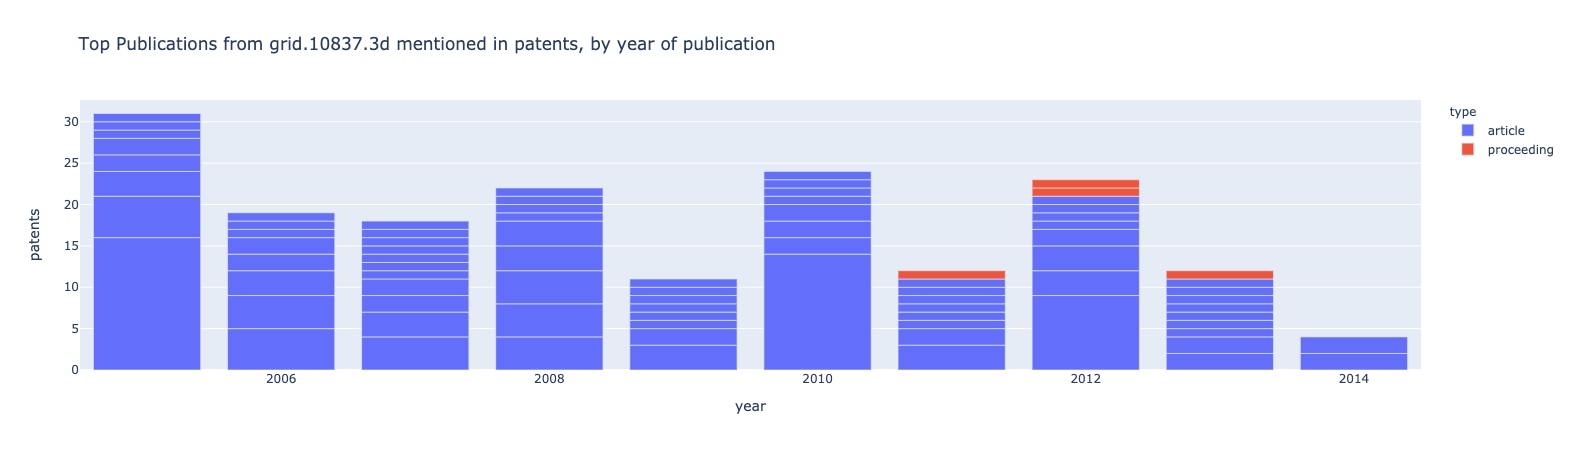

In [19]:
px.bar(pubs_cited[:1000], 
       color="type",
       x="year", y="patents", 
       hover_name="title",  hover_data=["journal.title"],
       title=f"Top Publications from {GRIDID} mentioned in patents, by year of publication")

### What are the main subject areas of referenced publications?

In [20]:
THRESHOLD_PUBS = 1000
citedids = list(pubs_cited[:THRESHOLD_PUBS]['id'])
pubs_categories_cited = pubs_categories[pubs_categories['id'].isin(citedids)]

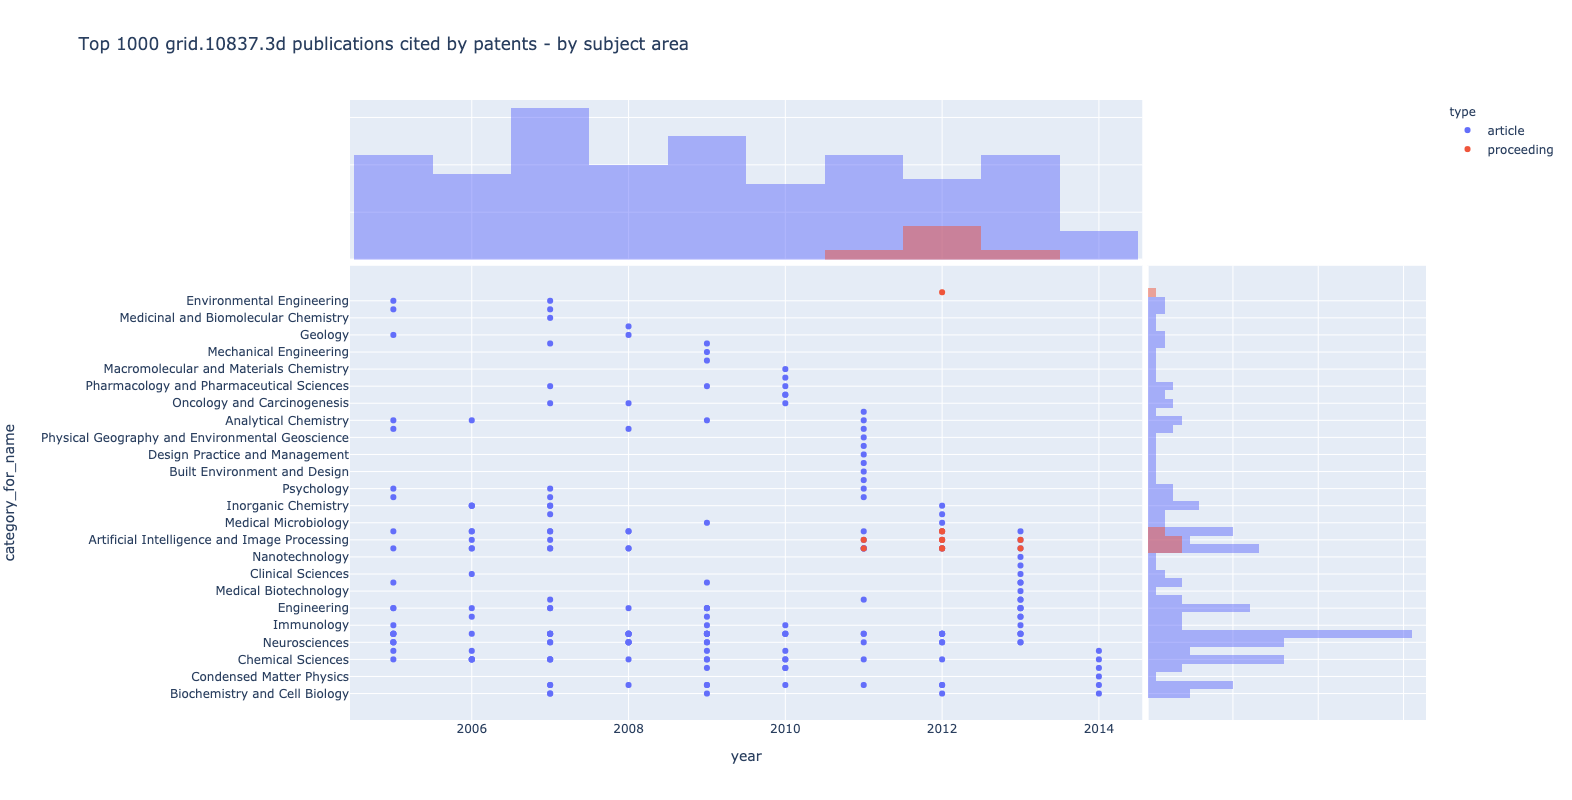

In [21]:
px.scatter(pubs_categories_cited, x="year", y="category_for_name", color="type", 
           hover_name="title", 
           hover_data=["doi", "year", "journal.title"],
           height=800,
           marginal_x="histogram", marginal_y="histogram", 
           title=f"Top {THRESHOLD_PUBS} {GRIDID} publications cited by patents - by subject area")

### Is there a correlation between publication citations and patents citations? 

Note: if the points on a scatterplot graph produce a lower-left-to-upper-right pattern (see below), that is indicative of a positive correlation between the two variables. This pattern means that when the score of one observation is high, we expect the score of the other observation to be high as well, and vice versa.

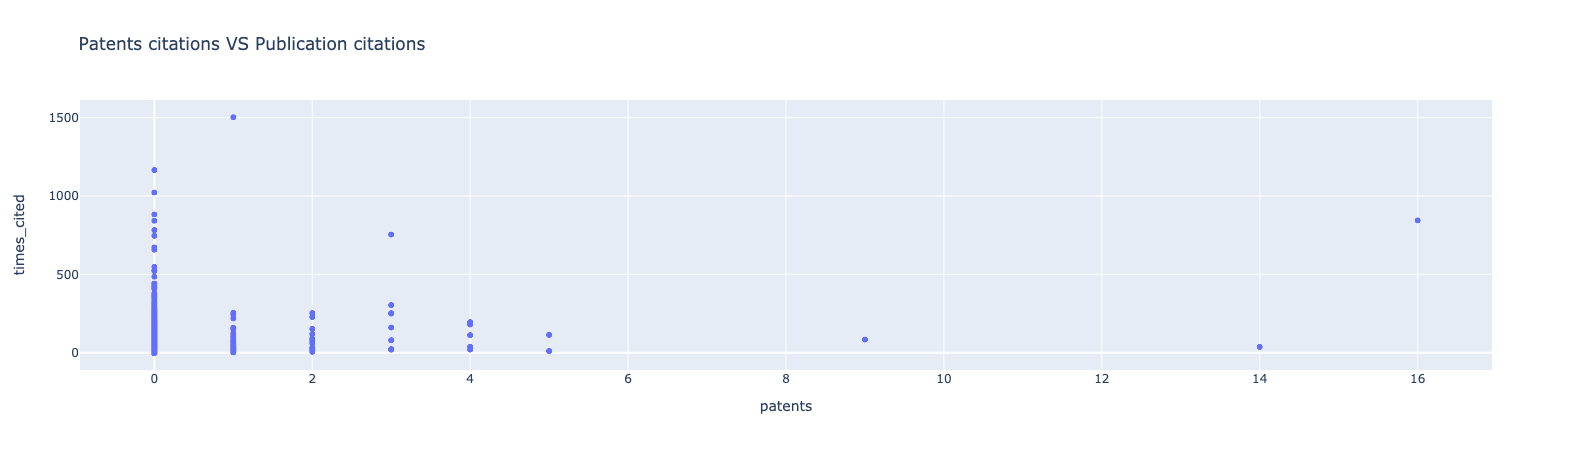

In [22]:
px.scatter(pubs, x="patents", y="times_cited", 
           title=f"Patents citations VS Publication citations")

---
## Where to go from here

In this [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) tutorial we have seen how, starting from a GRID organization, it is possible to extract a) publications from authors associated to this organization, b) patents citing those publications (from any organization). 

This only scratches the surface of the possible applications of publication-patents linkage data, but hopefully it'll give you a few basic tools to get started building your own application. Here are some ideas for customizing this notebook:

* Change the GRID ID to another one you are more familiar with
* Use a different way to select publications: e.g. not using an organizations segment, but a category, a country, a funder or a combination of the many [Publication filters](https://docs.dimensions.ai/dsl/datasource-publications.html) available
* Do a more in-depth analysis of the patents inventors: do they have other publications linking to the publications they cite in patents? Are there patterns of collaborations with the institutions they cite? 